In [1]:
import scipy.linalg as la
from math_functions.Get_state_index import Get_State_index
from main_grape.Grape import Grape
%pylab inline
import random as rd
import time
from IPython import display

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Defining our modes of operation (specific to our experiment)

Modulation = True
Interpolation = True
D = True


In [ ]:
#Defining time scales
total_time = 5.0
steps = 300

#Defining H0
qubit_state_num = 4
alpha = 0.224574
freq_ge = 3.9225#GHz
ens = np.array([ 2*np.pi*ii*(freq_ge - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
mode_state_num = 3
qm_g1 = 2*np.pi*0.1 #GHz
mode_freq1 = 6.0 #GHz
mode_ens1 = np.array([ 2*np.pi*ii*(mode_freq1) for ii in np.arange(mode_state_num)])
qm_g2 = 2*np.pi*0.1 #GHz
mode_freq2 = 6.5 #GHz
mode_ens2 = np.array([ 2*np.pi*ii*(mode_freq2) for ii in np.arange(mode_state_num)])
state_num = qubit_state_num * (mode_state_num**2)
Q_x   = np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1)
Q_z   = np.diag(np.arange(0,qubit_state_num))
M_x = np.diag(np.sqrt(np.arange(1,mode_state_num)),1)+np.diag(np.sqrt(np.arange(1,mode_state_num)),-1)
I_q = np.identity(qubit_state_num)
I_m = np.identity(mode_state_num)
H_q = np.diag(ens)
H_m1 = np.diag(mode_ens1)
H_m2 = np.diag(mode_ens2)
H0 = np.kron(H_q,np.kron(I_m,I_m)) + np.kron(I_q,np.kron(H_m1,I_m)) +\
        np.kron(I_q,np.kron(I_m,H_m2)) + qm_g1*np.kron(Q_x,np.kron(M_x,I_m)) +\
        qm_g2*np.kron(Q_x,np.kron(I_m,M_x))
        
#Defining Dressed information for our multimode exp        
w_c, v_c = la.eig(H0)
dressed=[]
if D:
    for ii in range (len(v_c)):
        index=np.argmax(np.abs(v_c[:,ii]))
        if index not in dressed:
            dressed.append(index)
        else:
            temp= (np.abs(v_c[:,ii])).tolist()
            while index in dressed:

                temp.remove(max(temp))
                index2= np.argmax(np.array(temp))

                if index2<index:
                            #dressed.append(index2)
                    index=index2
                else:
                            #dressed.append(index2-1)
                    index=index2+1
            dressed.append(index)

#Defining Forbidden sates
states_h = range(3*mode_state_num**2,4*mode_state_num**2)
states_gef02 = [2,mode_state_num**2+2,2*mode_state_num**2+2]
states_gef20 = [2*mode_state_num,mode_state_num**2+2*mode_state_num,2*mode_state_num**2+2*mode_state_num]
states_forbidden_list = states_h + states_gef02 + states_gef20

#Defining Concerned states
states_concerned_list = [0,mode_state_num**2]

#Defining U (Target)
g00=Get_State_index(0,dressed)
e00=Get_State_index(mode_state_num**2,dressed)

if D:
    Ct_c= np.identity(state_num) - np.outer(v_c[:,g00], np.conjugate((v_c[:,g00])))
    Ct_c= Ct_c - np.outer(v_c[:,e00], np.conjugate((v_c[:,e00])))
    Ct_c= Ct_c + np.outer(v_c[:,e00], np.conjugate((v_c[:,g00])))
    Ct_c= Ct_c + np.outer(v_c[:,g00], np.conjugate((v_c[:,e00])))
else:
    Ut_c = la.expm((0-1j)*total_time*H0)
    Ct_c = Ut_c.copy()

    Ct_c[e00,g00] = 1
    Ct_c[g00,e00] = 1
    Ct_c[g00,g00] = 0
    Ct_c[e00,e00] = 0
U = Ct_c

#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num)
m_identity = np.identity(mode_state_num)
U0= np.kron(q_identity,np.kron(m_identity,m_identity))

#Defining control Hs
XI = np.kron(Q_x,np.kron(I_m,I_m))
ZI = np.kron(Q_z,np.kron(I_m,I_m))
Hops = [XI,ZI]
ops_max_amp = [4.0,2*np.pi*2.0]

#Defining convergence parameters
max_iterations = 5000
decay = max_iterations/2
convergence = {'rate':0.01, 'update_step':100, 'conv_target':1e-8, 'max_iterations':max_iterations,\
               'learning_rate_decay':decay}
reg_coeffs = {'alpha' : 0.01, 'z':0.01, 'dwdt':0.0001,'d2wdt2':0.001*0.0001, 'inter':100}
multi_mode = {'dressed':dressed, 'vectors':v_c, 'qnum':qubit_state_num, 'mnum': mode_state_num,\
              'f':freq_ge, 'es':w_c, 'g1':qm_g1}


Building graph:
State initialized.
Operators initialized.
Operators weight initialized.
Intermediate states initialized.
Propagator initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


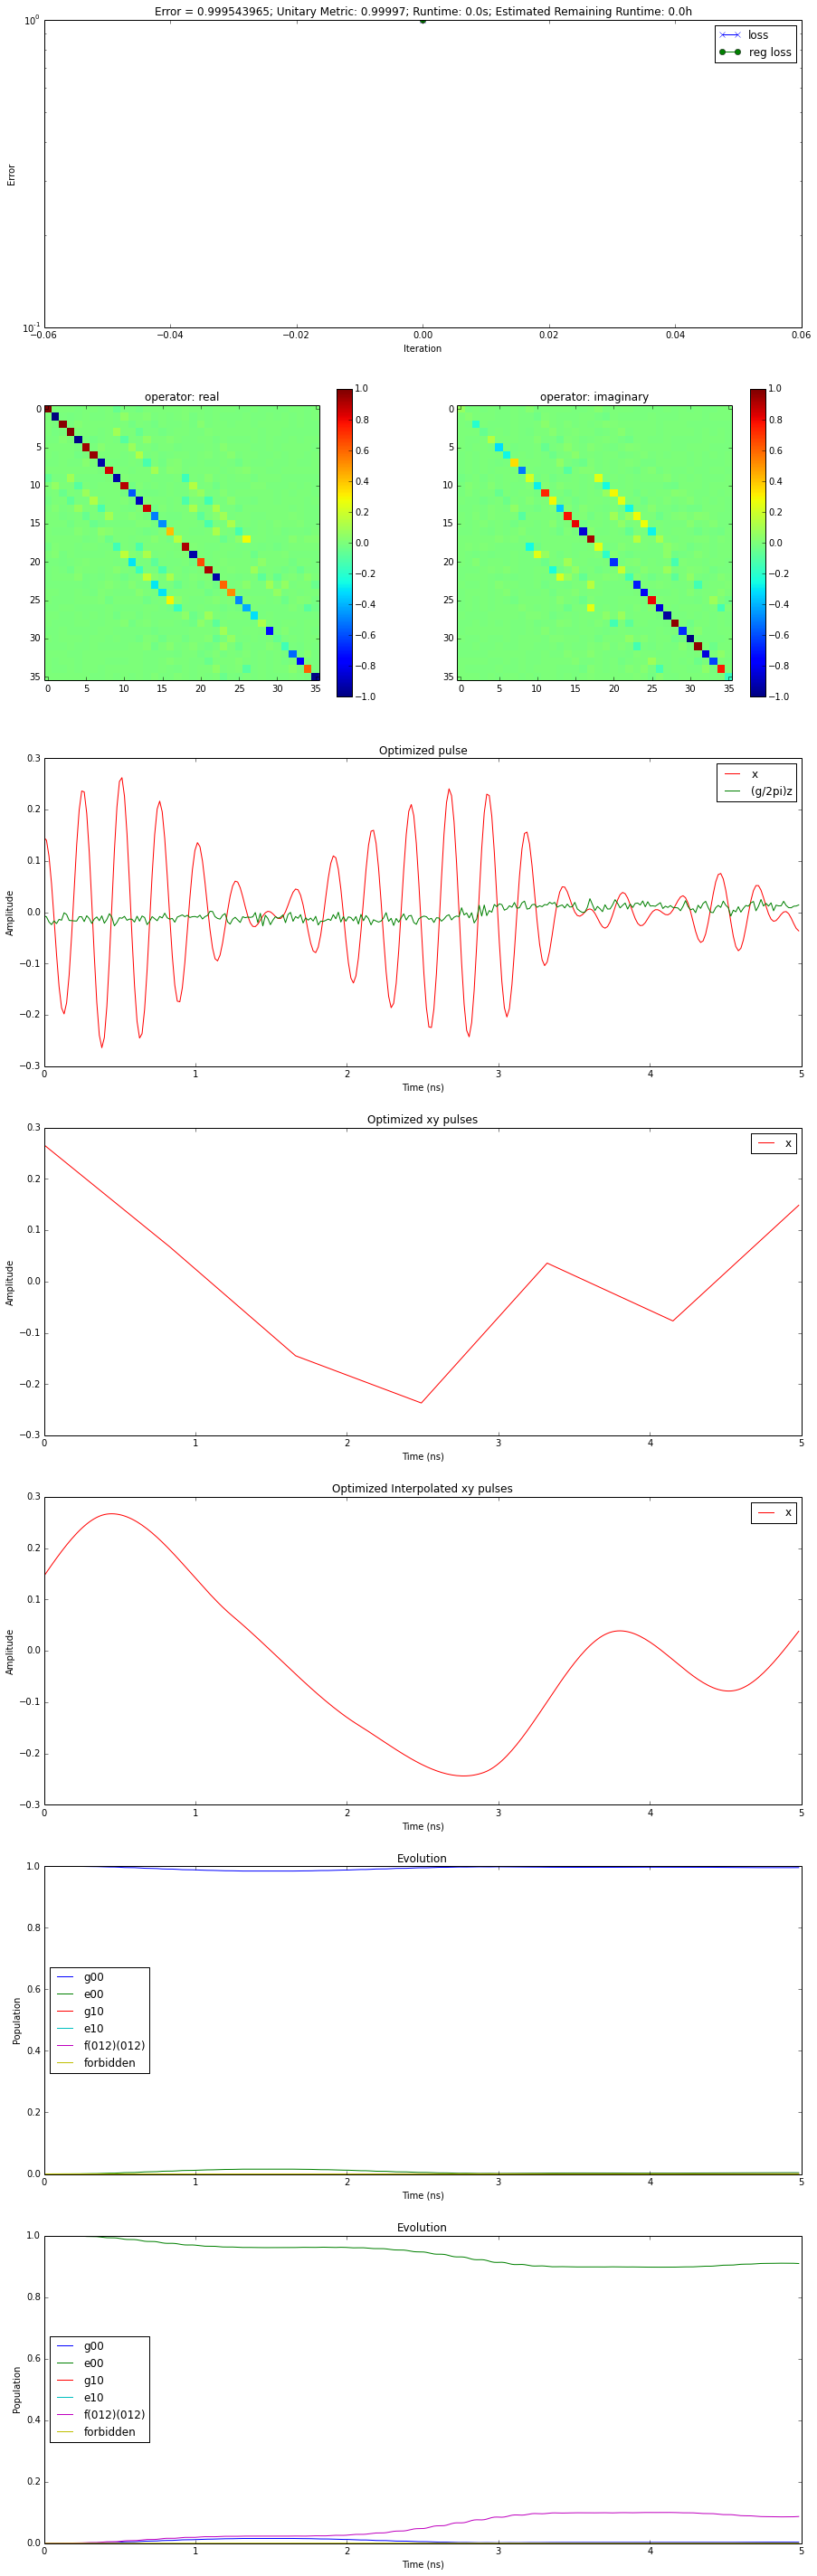

In [ ]:
Grape(H0,Hops,U,U0,total_time,steps,states_forbidden_list,states_concerned_list,convergence, reg_coeffs,\
      D,Modulation,Interpolation,multi_mode, ops_max_amp ,use_gpu = True)